### Неперсонализированная рекомендательная система
##### HR (c кроссвалидацией) 0.1024

# Games RSs

In [16]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "./reviews_Video_Games_5.json"
N = 10

## Загрузка данных

In [18]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [19]:
%%time
df = get_data_frame()

CPU times: user 2.1 s, sys: 88 ms, total: 2.19 s
Wall time: 2.19 s


## Готовим выборки

In [20]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [21]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


 ## Метрика

In [7]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [8]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

## Non-personalized RS

По каждой игре суммируем все рейтинги с дисконтом по времени отзыва 
(чем старее отзыв тем меньше вклад рейтинга в score). 

In [9]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid, top):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids, top):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid, top) for uid in uids}
    
class NonPersRecommender(BasicRecommender):
    def __init__(self, gamma=52.0):
        super(NonPersRecommender, self).__init__()
        self.gamma=gamma
    def fit(self,df):
        self.recs = self._prepare_recs(df,self.gamma)
        
    def _prepare_recs(self, df,gamma):
        scores=np.zeros(df.iid.max()+1)
        t0=df.dt.min()
        t1=df.dt.max()
        for t in df.itertuples():
                #экспотенциальное уменьшение влияния рейтинга
                #отдельного отзыва
                norm_time=(t1-t.dt)/(t1-t0)
                scores[t.iid]+=t.rating*(pow(np.e,-gamma*norm_time)) 
                
        rez=[]
        for iid in range(scores.shape[0]):
            rez.append((iid,scores[iid]))
            
        rez=sorted(rez,key=lambda x: x[1], reverse=True)  
        #print(rez[:10])
            
        return rez
    
    def get_recs(self, uid, top):
        return dict(self.recs[:top])
    
    def get_batch_recs(self, uids, top):
        non_pers_recs = self.get_recs(None, top)
        return {uid: non_pers_recs for uid in uids}

In [10]:
def check_recommender(recommender,test_collection): 
    """
        Проверяет рекомендатель на коллекции тестов и возвращаем худший HR на этой коллекции
    """
    values=[]
    for training_df,test_df,test_dict in test_collection:
        recommender.fit(training_df)
        recs_dict=recommender.get_batch_recs(test_df.uid,N)
        value=hit_ratio(recs_dict,test_dict)    
        values.append(value)
    return np.min(values)

def gen_crossval_testcollection(training_df,divide_koefs,train_test_ratio=0.8):
    """
        Генерирует коллекцию train/test по данному датасету        
        
    """
    time0=training_df.dt.min()
    time1=training_df.dt.max()
    
    test_collection=[]
    for divide_koef in divide_koefs:
        part_df=training_df[training_df.dt<(time0+(time1-time0)*divide_koef)]
        threshold_time=part_df.dt.min()+(part_df.dt.max()-part_df.dt.min())*train_test_ratio
       
        a=part_df[part_df.dt<threshold_time]  #for train
        b=part_df[part_df.dt>=threshold_time] #for test
        b=b[b.uid.isin(a.uid) & b.iid.isin(a.iid)]
        test_collection.append((a,b,get_test_dict(b)))
    return test_collection

## Подбор параметра gamma используя кроссвалидацию:

In [11]:
%%time
import time

cv_test_collection=gen_crossval_testcollection(training_df,np.linspace(0.1,1.0,10))
cv_results=[]
target_results=[]
gammas=[]
for gamma in range(0,70,1):
    start_time=time.time()
    recommender=NonPersRecommender(gamma=gamma)
    
    cv_result=check_recommender(recommender,cv_test_collection)
    target_result=check_recommender(recommender,[(training_df,test_df,test_dict)])
    
    target_results.append(target_result)
    cv_results.append(cv_result)
    gammas.append(gamma)    
    
    print ("gamma: %0.1f   cross_val_result: %0.5f   target_result: %0.5f  time: %0.1f sec"%
           (gamma,cv_result,target_result,time.time()-start_time))
cv_best_gamma=gammas[np.argmax(cv_results)]
cv_best_hr=max(cv_results)

gamma: 0.0   cross_val_result: 0.02507   target_result: 0.04035  time: 0.9 sec
gamma: 1.0   cross_val_result: 0.03721   target_result: 0.07982  time: 1.0 sec
gamma: 2.0   cross_val_result: 0.04652   target_result: 0.08232  time: 1.0 sec
gamma: 3.0   cross_val_result: 0.04652   target_result: 0.08584  time: 1.0 sec
gamma: 4.0   cross_val_result: 0.04015   target_result: 0.08584  time: 1.0 sec
gamma: 5.0   cross_val_result: 0.05258   target_result: 0.09420  time: 1.0 sec
gamma: 6.0   cross_val_result: 0.05695   target_result: 0.09420  time: 1.0 sec
gamma: 7.0   cross_val_result: 0.05764   target_result: 0.09420  time: 1.0 sec
gamma: 8.0   cross_val_result: 0.05764   target_result: 0.09420  time: 1.0 sec
gamma: 9.0   cross_val_result: 0.06081   target_result: 0.08819  time: 1.0 sec
gamma: 10.0   cross_val_result: 0.06081   target_result: 0.08819  time: 1.0 sec
gamma: 11.0   cross_val_result: 0.06081   target_result: 0.08819  time: 1.0 sec
gamma: 12.0   cross_val_result: 0.06081   target_r

best_gamma: 52.0   cross_val_result: 0.10229 


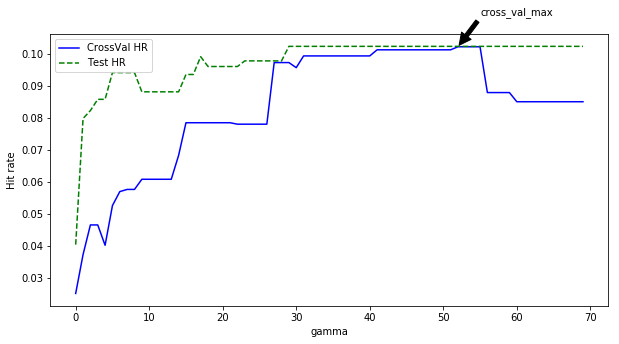

In [12]:
fig=plt.figure(figsize=(10,5))
plt.xlabel('gamma')
plt.ylabel('Hit rate')

cv_graph,=plt.plot(gammas, cv_results, 'b',label='CrossVal HR')
test_graph,=plt.plot(gammas, target_results, 'g--',label='Test HR')
plt.annotate('cross_val_max', xy=(cv_best_gamma, cv_best_hr),  xytext=(cv_best_gamma+3, cv_best_hr+0.01),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.legend(handles=[cv_graph, test_graph])


print ("best_gamma: %0.1f   cross_val_result: %0.5f "%(cv_best_gamma,cv_best_hr))

## Финальный тест

In [23]:
%%time
recommender=NonPersRecommender(gamma=cv_best_gamma)
recommender.fit(training_df)
recs_dict=recommender.get_batch_recs(test_df.uid.unique(),N)
value=hit_ratio(recs_dict,test_dict)   
print("HR: ",value)

HR:  0.10242112986060162
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 332 ms
